In [ ]:
 #yahoo finance as data source
!pip install yfinance
import yfinance as yf

In [ ]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'TATAMOTORS.NS'

In [ ]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-16,233.800003,234.100006,225.649994,230.500000,229.783829,41653657
2019-04-18,231.899994,239.300003,230.600006,236.250000,235.515976,42451178
2019-04-22,235.000000,239.350006,231.699997,234.850006,234.120331,30282217
2019-04-23,235.000000,235.850006,230.250000,231.649994,230.930252,18975358
2019-04-24,231.649994,232.949997,217.600006,223.600006,222.905273,50317411


In [ ]:
len(data)

1235

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-09,1021.000000,1029.500000,1005.000000,1008.500000,1008.500000,8539041
2024-04-10,1012.250000,1021.000000,1010.000000,1013.500000,1013.500000,4554077
2024-04-12,1014.000000,1029.000000,1013.500000,1018.500000,1018.500000,11575194
2024-04-15,998.099976,1006.950012,978.500000,998.799988,998.799988,12632409
2024-04-16,990.000000,1004.900024,982.099976,992.799988,992.799988,9574762


In [ ]:
opn = data[['Open']]

<Axes: xlabel='Date'>

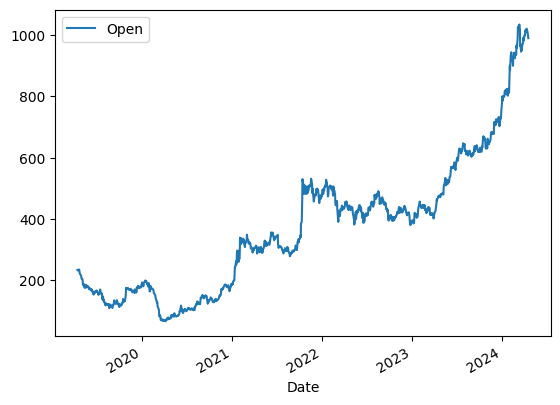

In [ ]:
opn.plot()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ds = opn.values

In [ ]:
ds

array([[ 233.80000305],
       [ 231.8999939 ],
       [ 235.        ],
       ...,
       [1014.        ],
       [ 998.09997559],
       [ 990.        ]])

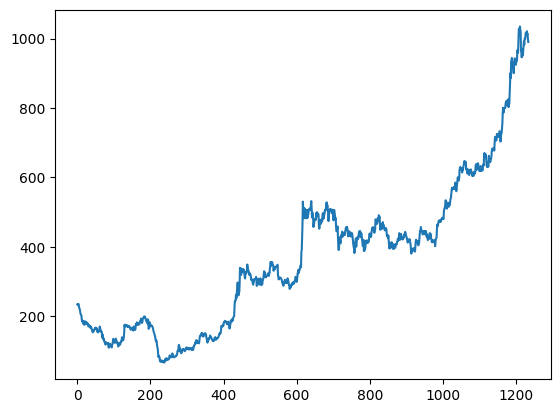

In [ ]:
plt.plot(ds)

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
len(ds_scaled), len(ds)

(1235, 1235)

In [ ]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
train_size,test_size

(864, 371)

In [ ]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [ ]:
len(ds_train),len(ds_test)

(864, 371)

In [ ]:
#creating dataset in time series for LSTM model
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [ ]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [ ]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 11s 376ms/step - loss: 0.0265 - val_loss: 0.0397
Epoch 2/100
12/12 [==============================] - 3s 276ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 3/100
12/12 [==============================] - 2s 196ms/step - loss: 0.0018 - val_loss: 9.1777e-04
Epoch 4/100
12/12 [==============================] - 3s 230ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/100
12/12 [==============================] - 5s 411ms/step - loss: 9.7723e-04 - val_loss: 0.0042
Epoch 6/100
12/12 [==============================] - 5s 432ms/step - loss: 9.2286e-04 - val_loss: 0.0039
Epoch 7/100
12/12 [==============================] - 5s 435ms/step - loss: 8.8971e-04 - val_loss: 0.0048
Epoch 8/100
12/12 [==============================] - 6s 483ms/step - loss: 8.5247e-04 - val_loss: 0.0040
Epoch 9/100
12/12 [==============================] - 5s 402ms/step - loss: 7.8041e-04 - val_loss: 0.0027
Epoch 10/100
12/12 [==============================] - 4s 333ms/ste

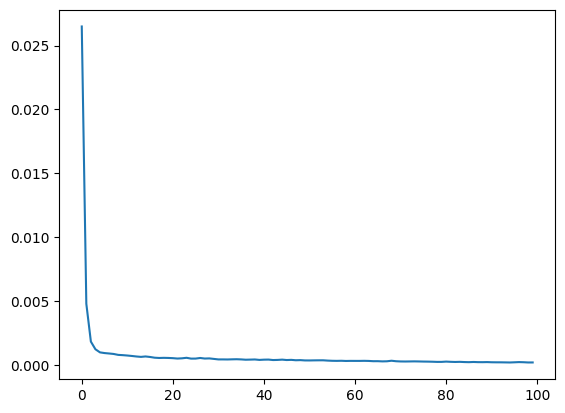

In [ ]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 1s 55ms/step


In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

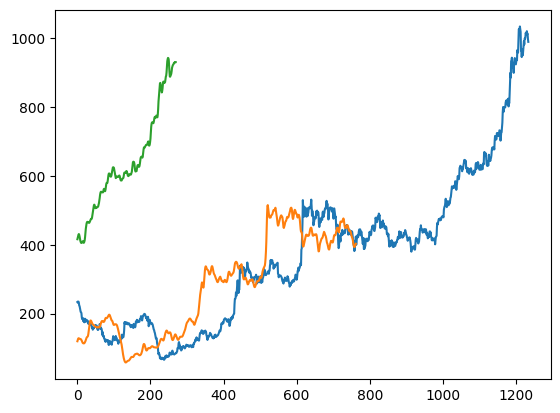

In [ ]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
type(train_predict)

numpy.ndarray

In [ ]:
test = np.vstack((train_predict,test_predict))

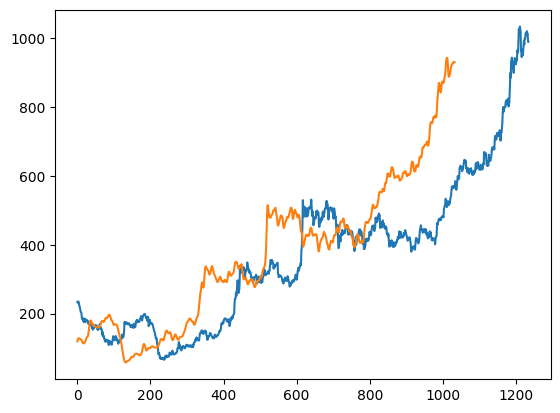

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [ ]:
len(ds_test)

371

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 101)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
import numpy as np

# Assuming you have a trained model named 'model' and an initial input sequence 'tmp_inp'
# Make sure to replace 'model' and 'tmp_inp' with your actual model and input sequence

# Define the number of steps for the sliding window
n_steps = 10

# Initialize the output list
lst_output = []

# Prediction loop for the next 30 days
for i in range(30):
    if len(tmp_inp) > n_steps:
        # Use the last n_steps values as input for prediction
        fut_inp = np.array(tmp_inp[-n_steps:])
        fut_inp = fut_inp.reshape(1, n_steps, 1)
        yhat = model.predict(fut_inp, verbose=0)

        # Extend input sequence and output list
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

    else:
        # If the input sequence is not long enough, use the entire sequence for prediction
        fut_inp = np.array(tmp_inp)
        fut_inp = fut_inp.reshape(1, len(tmp_inp), 1)
        yhat = model.predict(fut_inp, verbose=0)

        # Extend input sequence and output list
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

# Print the predicted output for the next 30 days
print(lst_output)


[[0.8541766405105591], [0.8208369612693787], [0.7808381915092468], [0.7426522970199585], [0.70808345079422], [0.6768608689308167], [0.6483904719352722], [0.6222727298736572], [0.5982656478881836], [0.5763379335403442], [0.5565721392631531], [0.538512647151947], [0.5223370790481567], [0.5078782439231873], [0.49502554535865784], [0.48368898034095764], [0.4737775921821594], [0.4651946723461151], [0.45783817768096924], [0.4516037404537201], [0.44638991355895996], [0.44210153818130493], [0.4386357367038727], [0.43590211868286133], [0.43381163477897644], [0.4322805404663086], [0.43123000860214233], [0.4305882453918457], [0.43028879165649414], [0.43027162551879883]]


In [ ]:
len(ds_scaled)

1235

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

1235

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

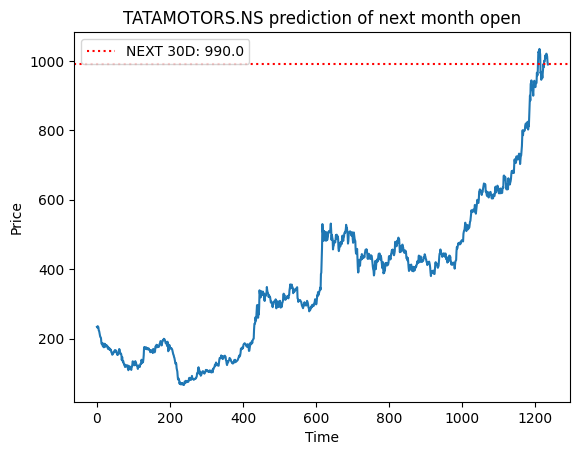

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()



In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)


2.15.0
2.15.0
